\newpage

# Chapter 5: The Forecaster's Toolbox 

In [234]:
#| warning : false

# data wrangling 
import pandas as pd 
import numpy as np

# data visuals
import matplotlib.pyplot as plt 
import seaborn as sns

# timeseries analysis
from darts import TimeSeries

# ts decomposition
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

# forecasting method
from darts.models import NaiveMean
from darts.models import NaiveSeasonal # K=1 for last value, K=4 for quarterly data
from darts.models import NaiveDrift

# residual analysis
from darts.utils.statistics import plot_residuals_analysis

In [235]:
# | echo : false
pd.set_option('display.max_columns', 7)
plt.rcParams['figure.figsize'] = (10, 6)

Resource: 

* [Darts Documentation](https://unit8co.github.io/darts/quickstart/00-quickstart.html)

## Exercise 1

Produce forecasts for the following series using whichever of NAIVE(y), SNAIVE(y) or RW(y ~ drift()) is more appropriate in each case:

* Australian Population (global_economy)

* Bricks (aus_production)

* NSW Lambs (aus_livestock)

* Household wealth (hh_budget).

* Australian takeaway food turnover (aus_retail).

In [236]:
# | warning : false

# reading in the data
df_global_economy = pd.read_csv("../rdata/global_economy.csv", parse_dates=['Year'])
df_production= pd.read_csv("../rdata/aus_production.csv", parse_dates=['Quarter'])
df_livestock = pd.read_csv("../rdata/aus_livestock.csv", parse_dates=['Month'])
df_budget = pd.read_csv("../rdata/hh_budget.csv", parse_dates=['Year'])
df_retail = pd.read_csv("../rdata/aus_retail.csv",parse_dates=['Month'])

C:\Users\nickc\AppData\Local\Temp\ipykernel_8012\2265436072.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_production= pd.read_csv("../rdata/aus_production.csv", parse_dates=['Quarter'])
C:\Users\nickc\AppData\Local\Temp\ipykernel_8012\2265436072.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_livestock = pd.read_csv("../rdata/aus_livestock.csv", parse_dates=['Month'])


C:\Users\nickc\AppData\Local\Temp\ipykernel_8012\2265436072.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_retail = pd.read_csv("../rdata/aus_retail.csv",parse_dates=['Month'])


### Australian Population from `global_economy` 

In [237]:
# filter australia
df_aus = df_global_economy.query('Country == "Australia"')

<Axes: xlabel='Year'>

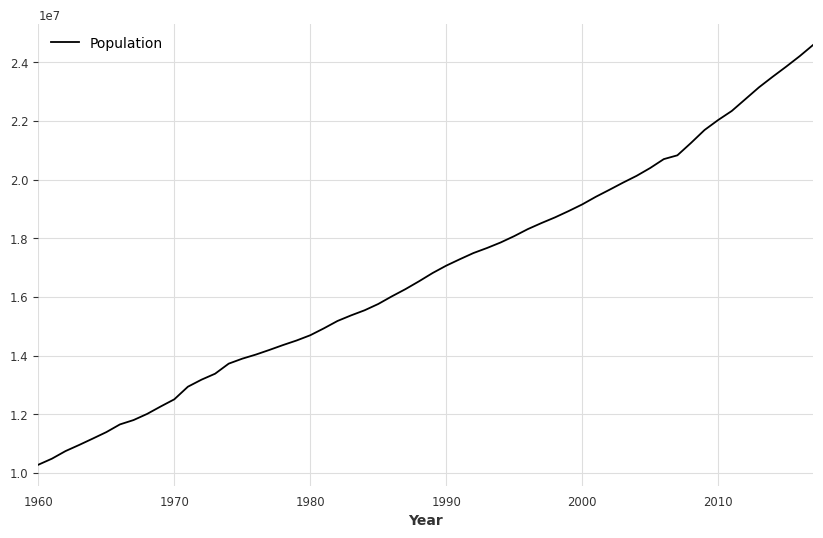

In [238]:
# plot australian timeseries pop
df_aus_pop = df_aus[['Year', 'Population']]
df_aus_pop.set_index('Year', inplace=True)
df_aus_pop.plot()


The Australian Populatiion has near perfect linear growth from the 1960 to 2020. Before, choosing which forecasting method to go with. I would like to see the decomposition of this time series just to make sure that my initial observation of no seasonality is correct.

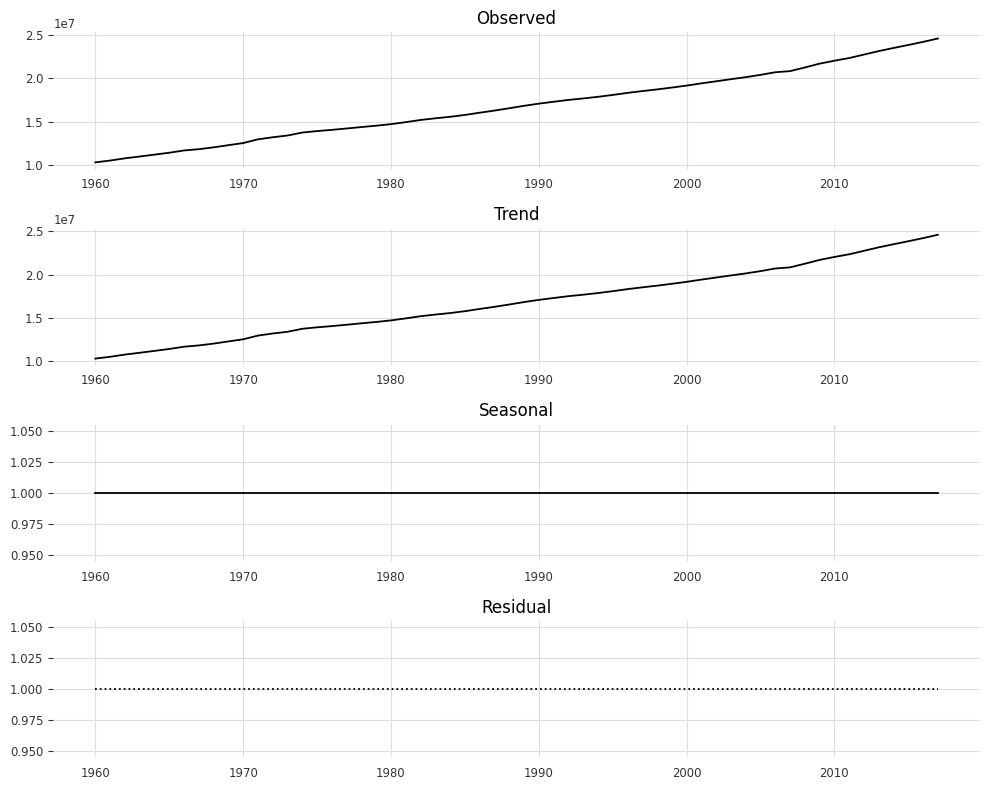

In [239]:
# decompose this ts 
decomposition = seasonal_decompose(df_aus_pop.Population, period = 1, model="multiplicative")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.plot(decomposition.observed)
ax1.set_title('Observed')

ax2.plot(decomposition.trend)
ax2.set_title('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('Seasonal')

ax4.plot(decomposition.resid, linestyle = "dotted", markersize = 10)
ax4.set_title('Residual')

plt.tight_layout()
plt.show()

The trend line captures almost all of the observed data indicated that the seasonal component is constant at a value of 1. Thus, I believe that using the Drift method would be the most appropriate for this timeseries since it exhibits no seasonality and a overal upward trend. Wherein our forecast cast would be the average change seen in the data.

In [240]:
# convert df to ts 
series = TimeSeries.from_dataframe(df_aus,'Year', 'Population')


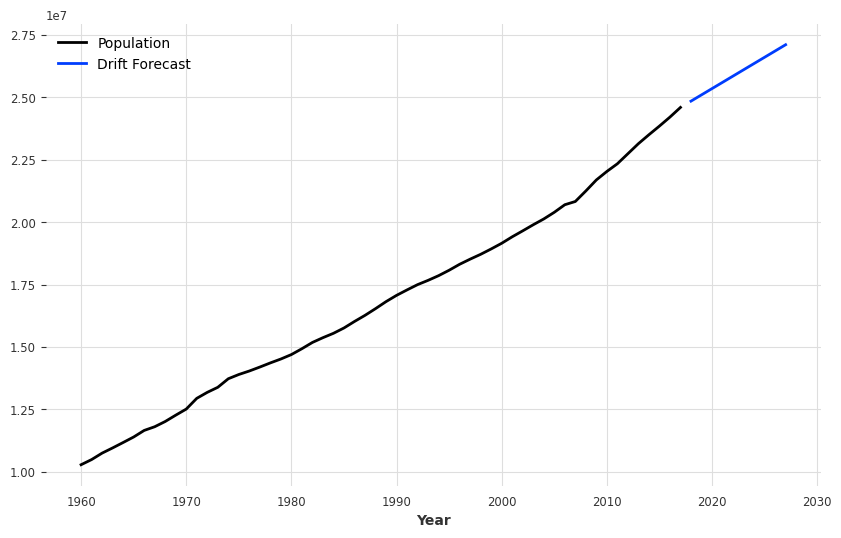

In [241]:
drift = NaiveDrift()

drift.fit(series)

forecast = drift.predict(10) # 10 timesteps
series.plot()
forecast.plot(label='Drift Forecast', low_quantile = 0.05, high_quantile=0.95)
plt.legend()

From the eye test, we observe that the Drift forecast is in-line with the data. It reasonable to agree with the forecast since the timeseries demonstrates an linear growth in population.

### Bricks from `aus_production`

In [242]:
df_bricks = df_production[['Quarter', 'Bricks']]

<Axes: xlabel='Quarter'>

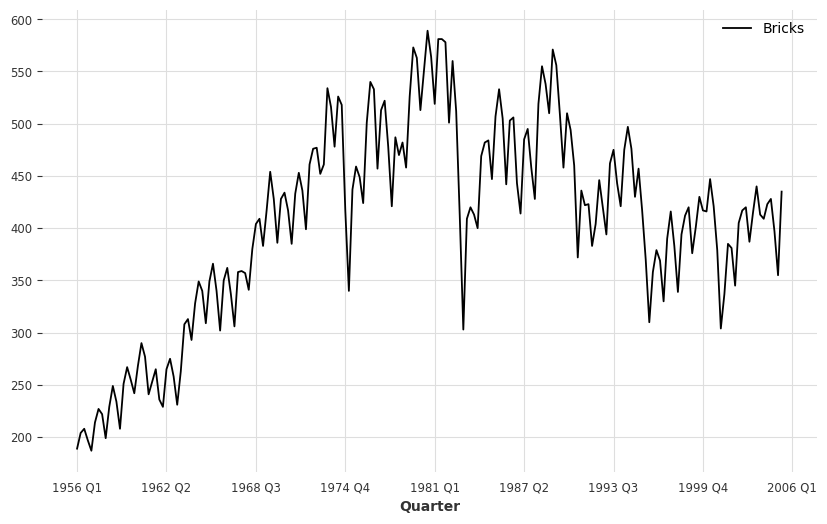

In [243]:
df_bricks.set_index('Quarter').plot()

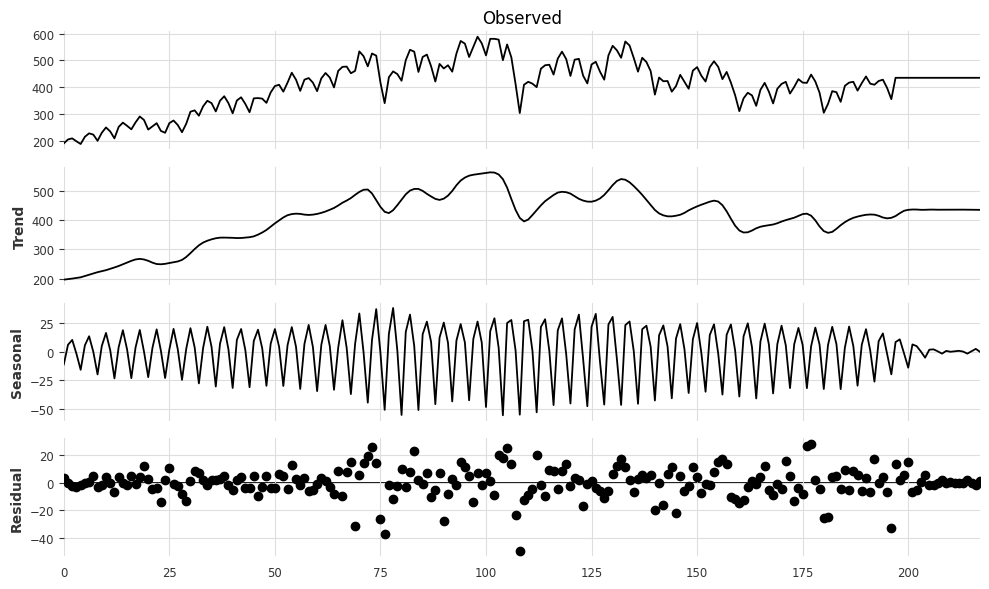

In [244]:
#| warning : false

bricks_plot = df_bricks.set_index('Quarter')
bricks_plot['Bricks'] = bricks_plot['Bricks'].ffill()

decom = STL(bricks_plot['Bricks'].values, period = 4).fit()
decom.plot()
plt.show()

We see a high frequency of the seasonality component while it is unclear whether the trend line is increasing or decreasing. Thus, we believe that using the seasonal naive would be best for forecasting this particular time series. 

In [245]:
df_bricks = df_bricks.dropna() # missing a data at the tail() 

# format datetime to accomodate the input for darts library
df_bricks['Quarter'] = pd.to_datetime(df_bricks['Quarter'].astype(str), format='%Y Q%m')

df_bricks.set_index('Quarter')

,Bricks
Quarter,
1956-01-01,189.0
1956-02-01,204.0
1956-03-01,208.0
1956-04-01,197.0
1957-01-01,187.0
...,...
2004-02-01,423.0
2004-03-01,428.0
2004-04-01,397.0


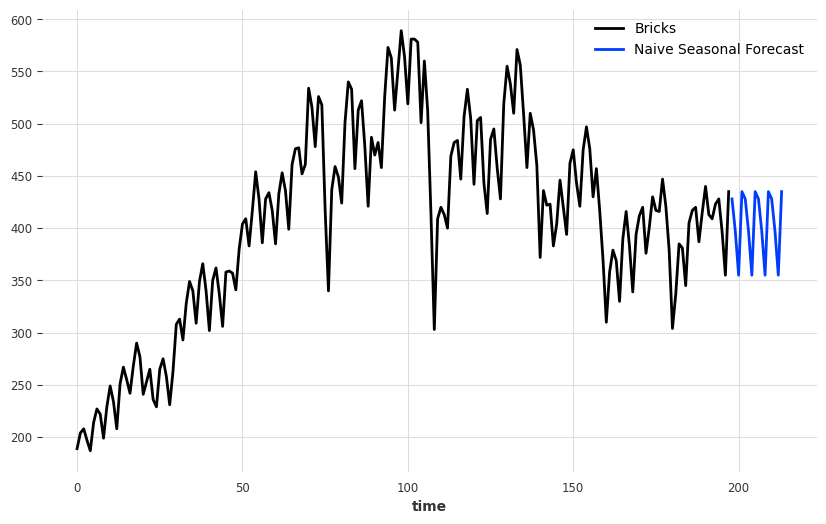

In [246]:
# remove time col since it is set as the index
series = TimeSeries.from_dataframe(df_bricks, value_cols='Bricks', fill_missing_dates=True)

seasonal = NaiveSeasonal(K=4) # K=4 for quarterly data

seasonal.fit(series)

forecast = seasonal.predict(16)

series.plot()
forecast.plot(label='Naive Seasonal Forecast')
plt.legend()

### NSW Lambs from `aus_livestock`

In [247]:
display(df_livestock.State.unique())
display(df_livestock.Animal.unique())

array(['Australian Capital Territory', 'New South Wales',
       'Northern Territory', 'Queensland', 'South Australia', 'Tasmania',
       'Victoria', 'Western Australia'], dtype=object)

array(['Bulls, bullocks and steers', 'Calves', 'Cattle (excl. calves)',
       'Cows and heifers', 'Lambs', 'Pigs', 'Sheep'], dtype=object)

Assuming NSW means New South Wales. So, we need to filter `df_livestock` of sheep from New South Wales.

In [248]:
df_sheep = df_livestock.query('Animal == "Sheep" & State == "New South Wales"')
df_sheep

,Unnamed: 0,Month,Animal,State,Count
25458,25459,1972-07-01,Sheep,New South Wales,669400.0
25459,25460,1972-08-01,Sheep,New South Wales,581100.0
25460,25461,1972-09-01,Sheep,New South Wales,468100.0
25461,25462,1972-10-01,Sheep,New South Wales,515300.0
25462,25463,1972-11-01,Sheep,New South Wales,564500.0
...,...,...,...,...,...
26011,26012,2018-08-01,Sheep,New South Wales,245900.0
26012,26013,2018-09-01,Sheep,New South Wales,236800.0
26013,26014,2018-10-01,Sheep,New South Wales,277200.0
26014,26015,2018-11-01,Sheep,New South Wales,263600.0


Next, we want to see the timeseries.

<Axes: xlabel='Month'>

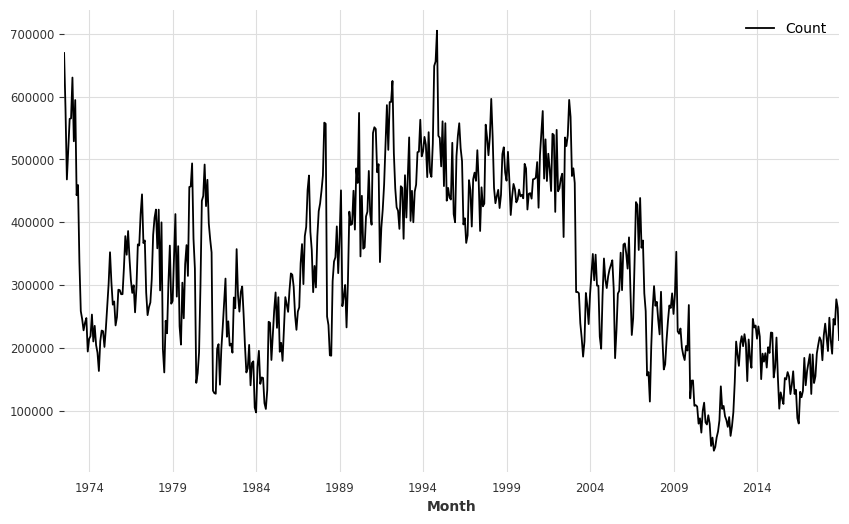

In [249]:
df_sheep[['Month', 'Count']].set_index(['Month']).plot()


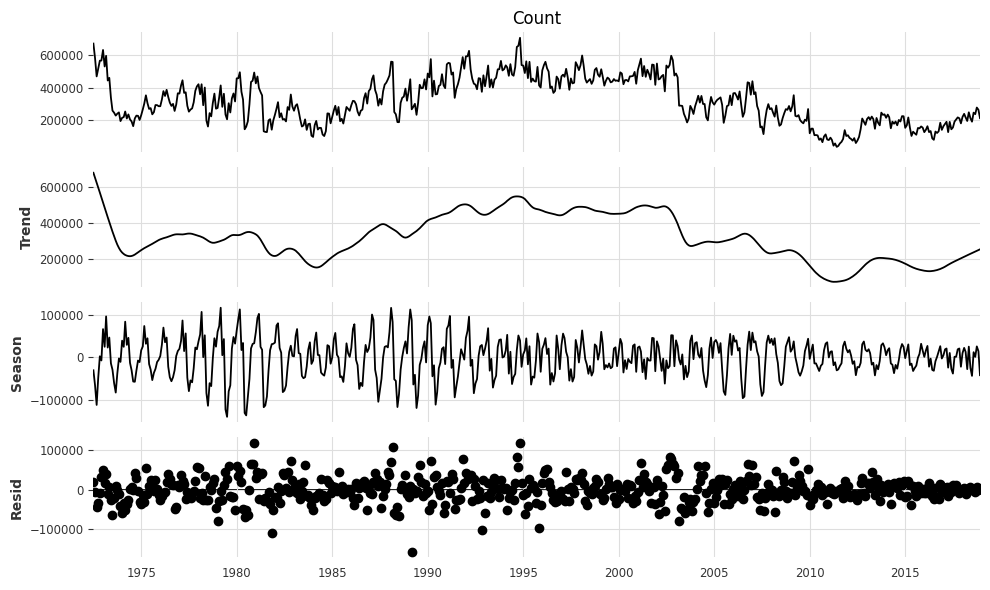

In [250]:
sheep = df_sheep.set_index('Month')
decomposition = STL(sheep['Count']).fit()
decomposition.plot()
plt.show()

We see that this time seres has no clear trend and inconsistent seasonality component which suggest that we use the Mean Naive method.

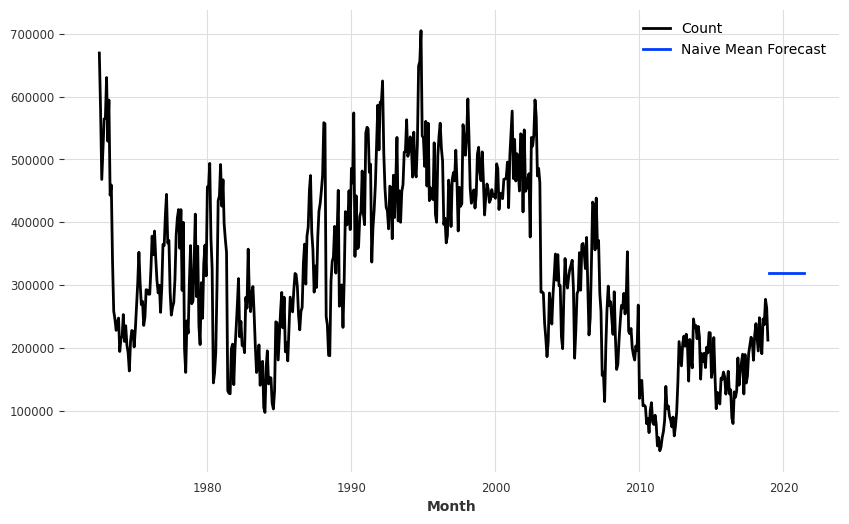

In [251]:
series = TimeSeries.from_dataframe(df_sheep, 'Month', 'Count')

model = NaiveMean() 
model.fit(series)
forecast = model.predict(30) # 30 timesteps in the future in this case 30 months

series.plot()
forecast.plot(label = 'Naive Mean Forecast')
plt.legend()

### Household Wealth from `hh_budget`

Let us see which columns and constrains we need to filter. We will need the `Year`, `Country` and `Wealth` columns. 

In [252]:
df_wealth = df_budget[['Year', 'Country', 'Wealth']]
df_wealth

,Year,Country,Wealth
0,1995-01-01,Australia,314.9344
1,1996-01-01,Australia,314.5559
2,1997-01-01,Australia,323.2357
3,1998-01-01,Australia,339.3139
4,1999-01-01,Australia,354.4382
...,...,...,...
83,2012-01-01,USA,514.4276
84,2013-01-01,USA,592.3568
85,2014-01-01,USA,596.4713
86,2015-01-01,USA,588.1454


So, we have annual data for wealth of four different countries. Based on the prior exercise, we can assume that we want the Australian data. 

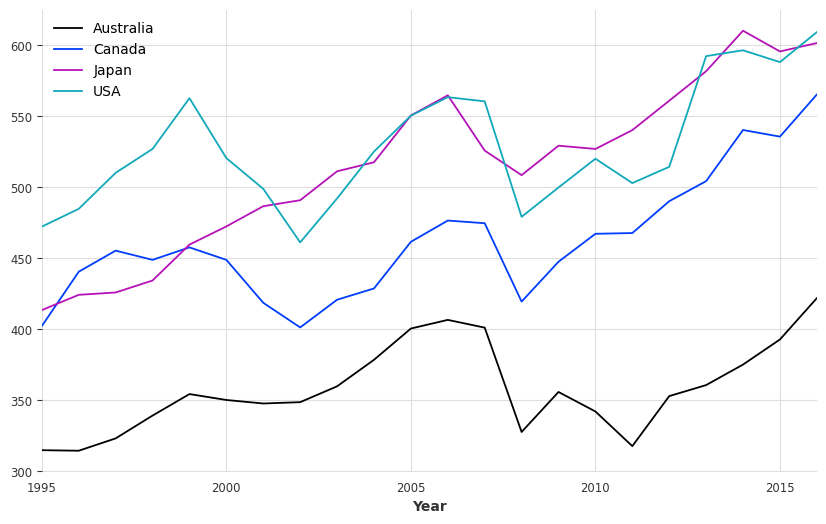

In [253]:
wealth = df_wealth
wealth = wealth.set_index(['Year'])

wealth.groupby('Country')['Wealth'].plot()
plt.legend()

In [254]:
aus_wealth = wealth.query('Country == "Australia"')

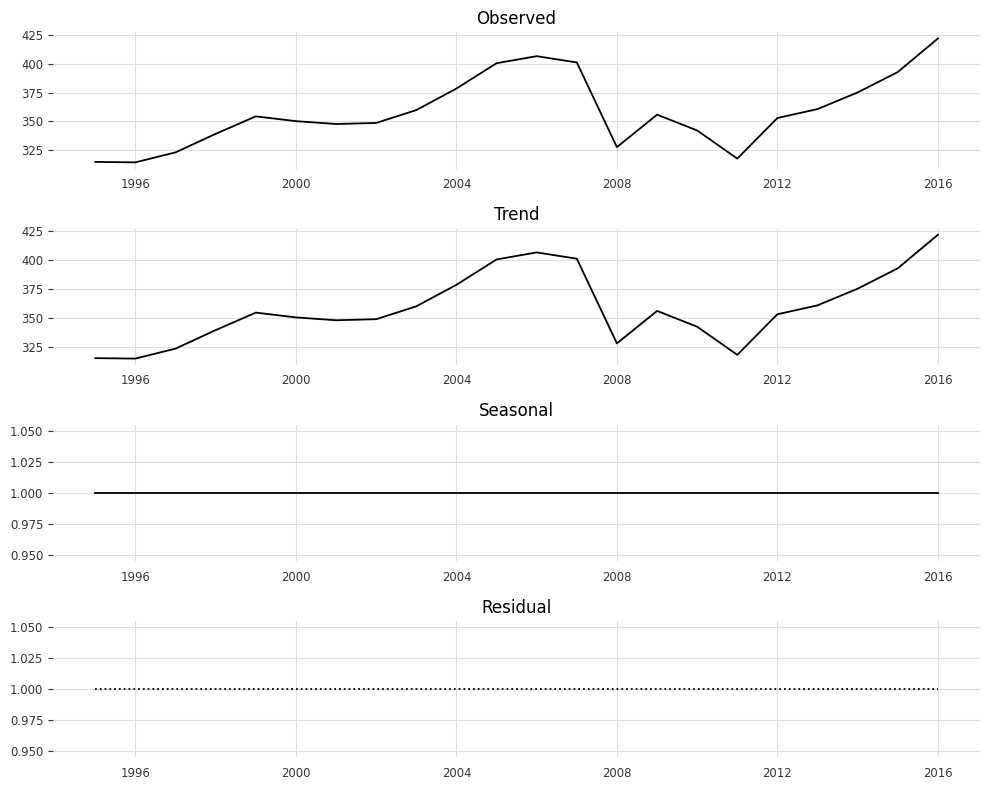

In [255]:
decomposition=seasonal_decompose(aus_wealth.Wealth, period=1,model="multiplicative")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.plot(decomposition.observed)
ax1.set_title('Observed')

ax2.plot(decomposition.trend)
ax2.set_title('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('Seasonal')

ax4.plot(decomposition.resid, linestyle = "dotted", markersize = 10)
ax4.set_title('Residual')

plt.tight_layout()
plt.show()


From the decomposition, it clear that there is minimal seasonality and the trend line is unclear without further analysis. Thus, we believe using Naive Mean forecast would be the best for this time series.

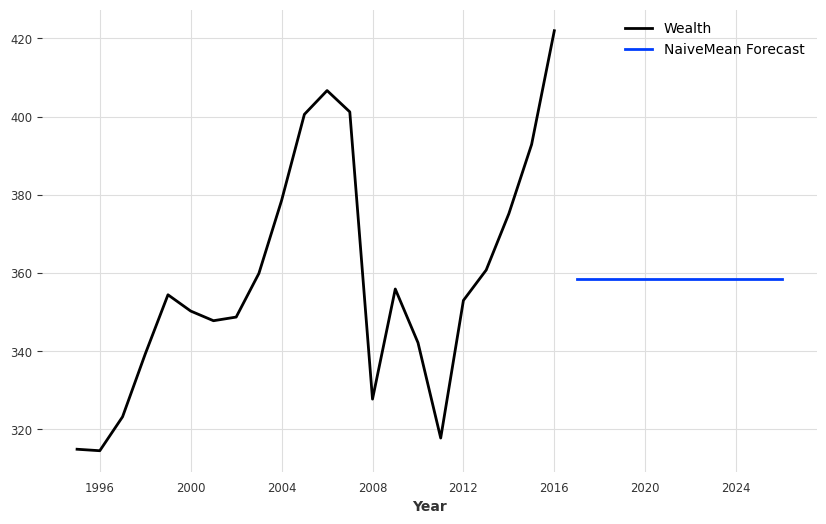

In [256]:
series = TimeSeries.from_dataframe(aus_wealth, value_cols='Wealth')

model = NaiveMean()

model.fit(series)

forecast = model.predict(10)

series.plot()
forecast.plot(label='NaiveMean Forecast')
plt.legend()

### Australian takeaway food turnover from `aus_retail`

We are going to filter take away food services in the Australian Capital Territory because we tried plotting all of the territories in one plot which leds to a overcrowded plot. Therefore, we will focus on the Australian Capital Regions.

In [257]:
df_takeaway = df_retail.query('Industry == "Takeaway food services" & State == "Australian Capital Territory"')
df_takeaway = df_takeaway[['Month', 'Turnover']]
df_takeaway.set_index('Month', inplace=True)

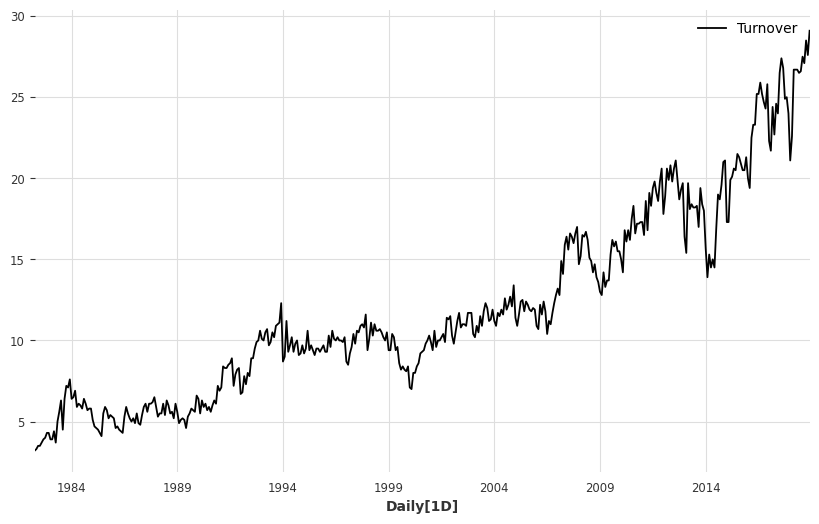

In [258]:
df_takeaway.plot()
plt.xlabel("Daily[1D]")
plt.show()

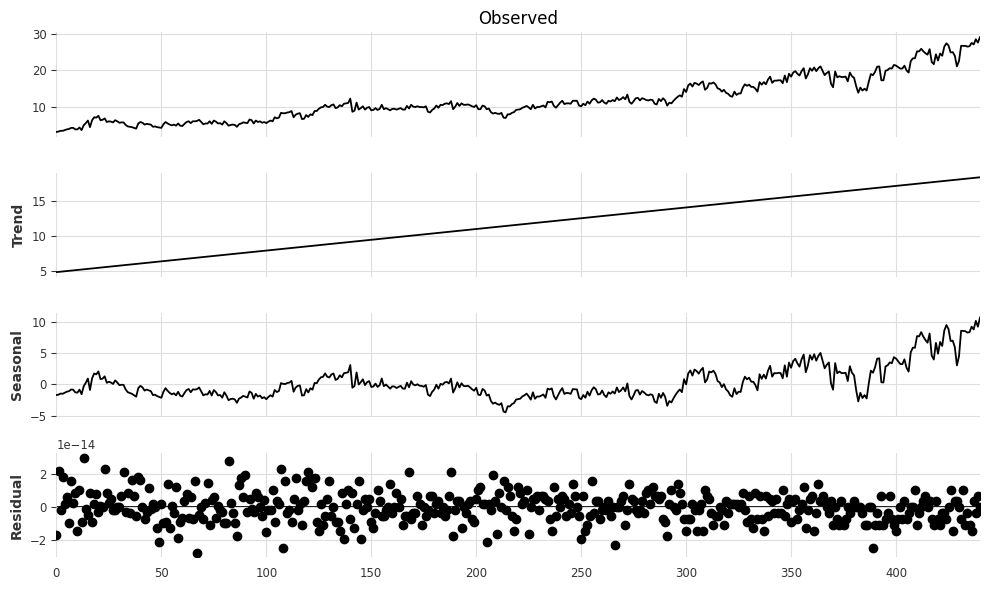

In [259]:
decomp = STL(df_takeaway['Turnover'].values, period=365).fit()
decomp.plot()
plt.show()


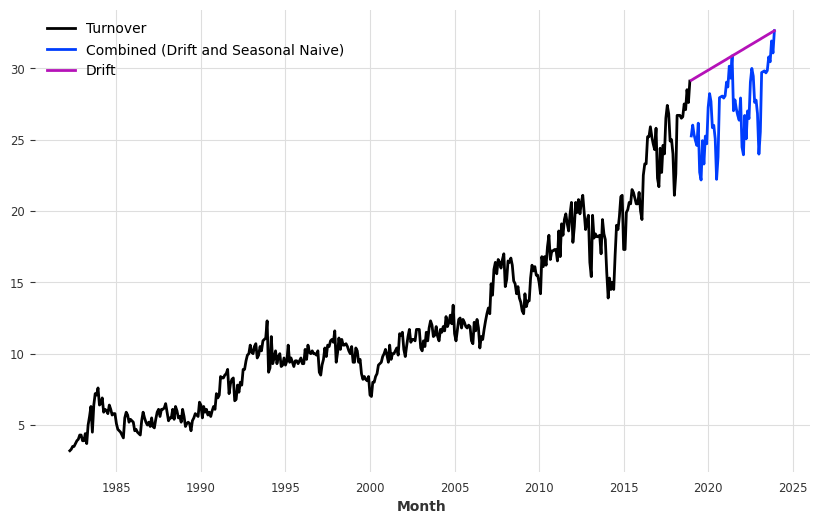

In [260]:
series = TimeSeries.from_dataframe(df_takeaway)

season_model = NaiveSeasonal(K=30) 
drift_model = NaiveDrift()

season_model.fit(series)
drift_model.fit(series)

seasonal_forecast = season_model.predict(60)
drift_forecast = drift_model.predict(60)

combined_forecast = seasonal_forecast + drift_forecast - series.last_value()

series.plot()
combined_forecast.plot(label='Combined (Drift and Seasonal Naive)')
drift_forecast.plot(label='Drift')
plt.legend()
plt.show()


After decomposing the timeseries and observing that its overall trend is increasing, we wanted to imploy a combination of the simple forecasting methods. There is some seasonality but it was unclear the whether the pattern was weeky or monthly. So, we decide to use bi-weekly to forcast this timeseries.


## Exercise 2

Use the Facebook stock price (data set gafa_stock) to do the following:


In [261]:
df_gafa_stock = pd.read_csv("../rdata/gafa_stock.csv", parse_dates = ['Date'], index_col = ['Date'])

fb_stock = df_gafa_stock.query('Symbol == "FB"')

fb_stock_close = fb_stock['Close']

fb_stock_close = fb_stock_close.rename_axis('Date').reset_index()


* Produce a time plot of the series.


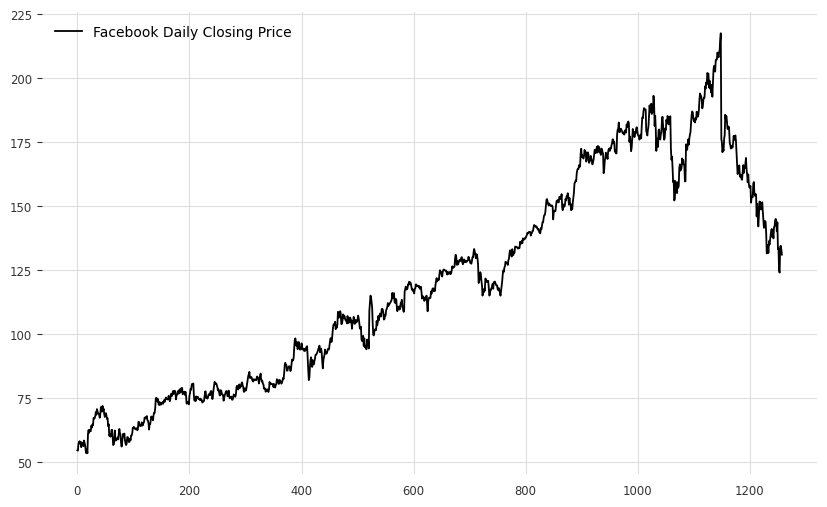

In [262]:
fb_stock_close['Close'].plot(label='Facebook Daily Closing Price')
plt.legend()
plt.show()


* Produce forecasts using the drift method and plot them.



* Show that the forecasts are identical to extending the line drawn between the first and last observations.


For the next two bullet points, we will create a drift forecast of the fb closing price data and then draw a dash line between the first and last values to determine whether the drift forecast is identical to the dash line.

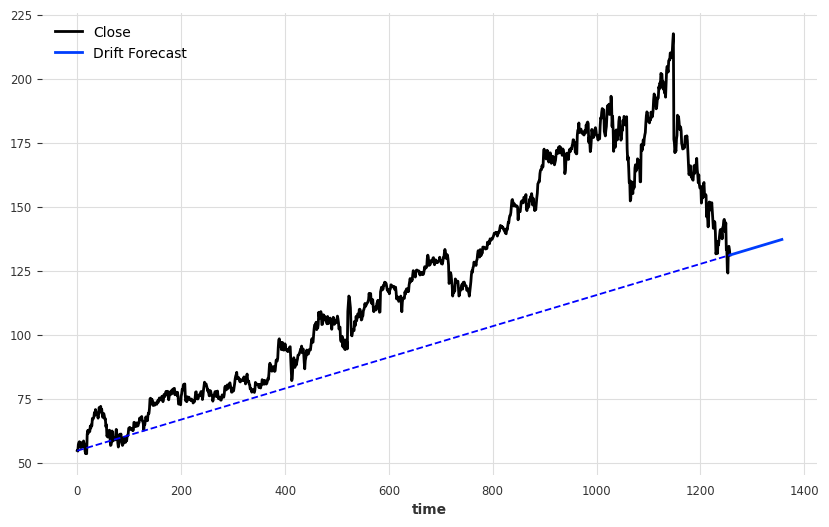

In [263]:

series = TimeSeries.from_dataframe(fb_stock_close, value_cols='Close')

drift = NaiveDrift()
drift.fit(series)

forecast = drift.predict(100) # predict the next 100 days since it is daily data

series.plot()
forecast.plot(label='Drift Forecast')

first_value = series.first_value()
last_value = series.last_value()

# superimpose dash line on plot
plt.plot([series.time_index[0], series.time_index[-1]], [first_value, last_value], '--', color = 'blue')

plt.legend()
plt.show()

The drift forecast is identical to the superimposed dashed line on the plot. 


* Try using some of the other benchmark functions to forecast the same data set. Which do you think is best? Why?

We can observe that the drift method does not capture the seasonal component of the data. So, we propose that a combination of NaiveSeaonal and the drift method might be a better bencamrk function to forecast. 

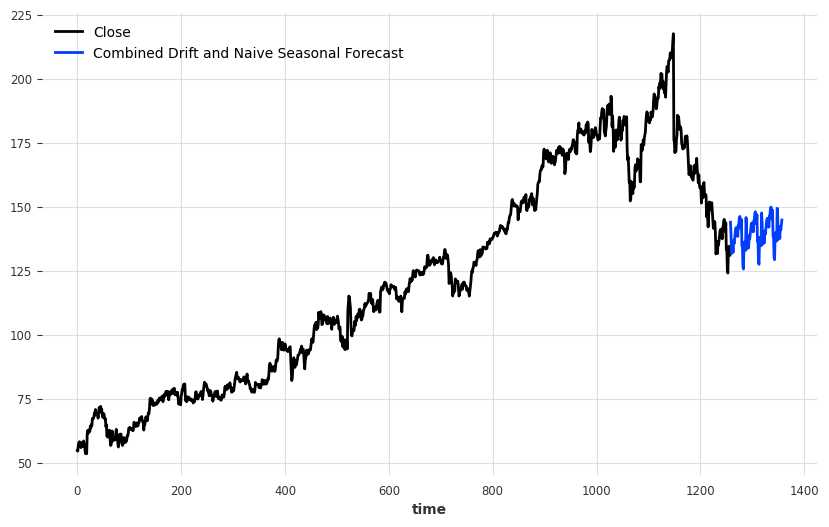

In [264]:
seasonal = NaiveSeasonal(K=30)
seasonal.fit(series)
seasonal_forecast = seasonal.predict(100)
combination = seasonal_forecast + forecast - series.last_value()

series.plot()
combination.plot(label="Combined Drift and Naive Seasonal Forecast")
plt.legend()
plt.show()

## Exercise 3

 Apply a seasonal naïve method to the quarterly Australian beer production data from 1992. Check if the residuals look like white noise, and plot the forecasts. The following code will help.

```{r}
# Extract data of interest
recent_production <- aus_production |>
  filter(year(Quarter) >= 1992)

# Define and estimate a model
fit <- recent_production |> model(SNAIVE(Beer))
#Look at the residuals

fit |> gg_tsresiduals()

# Look a some forecasts
fit |> forecast() |> autoplot(recent_production)
```
What do you conclude?

In [265]:
aus_beer = df_production[['Quarter', 'Beer']]
aus_beer = aus_beer.query('Quarter >= "1992 Q1"')


aus_beer['Quarter'] = pd.to_datetime(aus_beer['Quarter'].astype(str), format = "%Y Q%m")


In [266]:
aus_beer

,Quarter,Beer
144,1992-01-01,443
145,1992-02-01,410
146,1992-03-01,420
147,1992-04-01,532
148,1993-01-01,433
...,...,...
213,2009-02-01,398
214,2009-03-01,419
215,2009-04-01,488
216,2010-01-01,414


In [267]:

series = TimeSeries.from_dataframe(aus_beer, value_cols='Beer', freq=None)


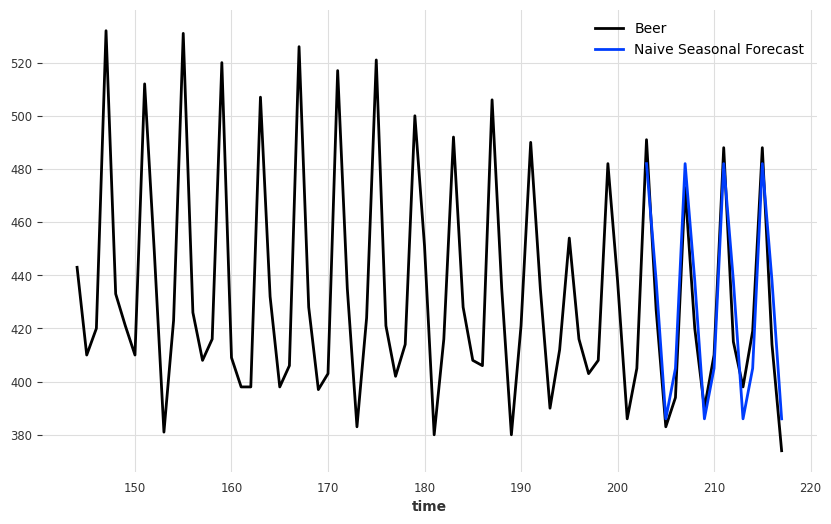

In [268]:

train_size = int(len(series) * 0.8)

train_series= series[:train_size]
test_series = series[train_size:]

model = NaiveSeasonal(K=4)

model.fit(train_series)

forecast = model.predict(len(test_series))

series.plot()
forecast.plot(label='Naive Seasonal Forecast')
plt.legend()
plt.show()

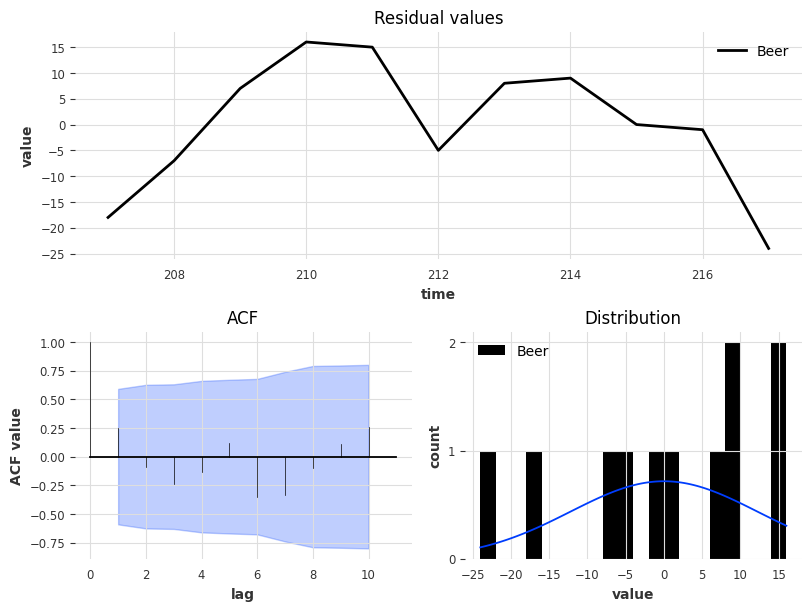

In [269]:
plot_residuals_analysis(model.residuals(test_series))

The residuals indicate that our current model isn't performing well for this data. Specifically, the mean of the residuals being far from zero suggests a some bias in our predictions. This suggests we should either significantly adjust the existing model's parameters or explore a fundamentally different forecasting approach altogether

## Exercise 4

Repeat the previous exercise using the Australian Exports series from global_economy and the Bricks series from aus_production. Use whichever of NAIVE() or SNAIVE() is more appropriate in each case

#### Australian Exports

In [270]:
aus_exports = df_aus[['Year', 'Exports']]

In [271]:
series = TimeSeries.from_dataframe(aus_exports, value_cols='Exports', fill_missing_dates=True)


In [272]:
train_size = int(len(series) * 0.8)

train_series= series[:train_size]
test_series = series[train_size:]

In [273]:
train_size

46

In [274]:
from darts.utils.statistics import check_seasonality
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train_series, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

Since this timeseries has no seasonality, we believe that using the Naive Method would be the better forecasting tool.

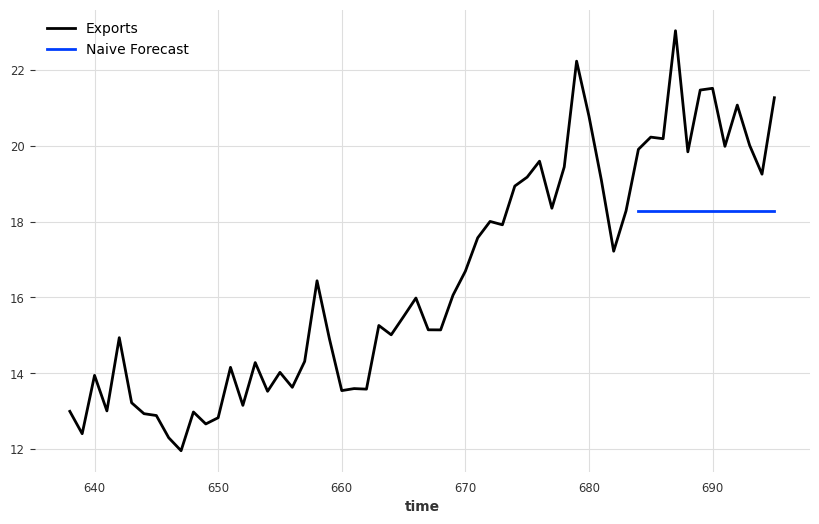

In [275]:

seasonal = NaiveSeasonal(K=1) 

seasonal.fit(train_series)

forecast = seasonal.predict(len(test_series))

series.plot()
forecast.plot(label='Naive Forecast')
plt.legend()
plt.show()

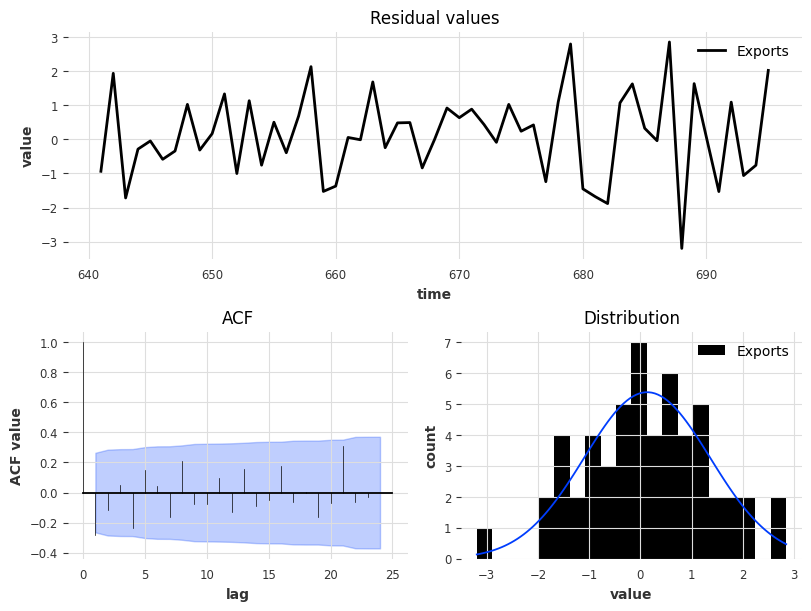

In [276]:
plot_residuals_analysis(seasonal.residuals(series))

#### Australian Bricks

In [277]:

series = TimeSeries.from_dataframe(df_bricks, value_cols='Bricks', freq=None)

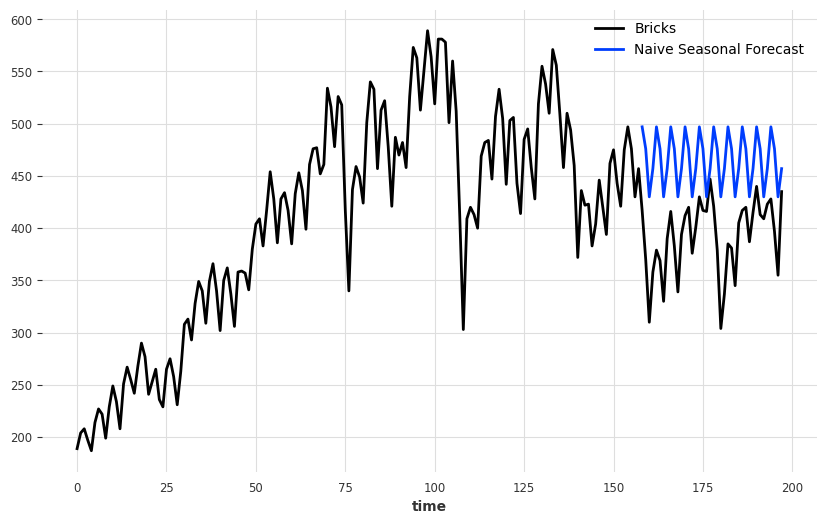

In [278]:
train_size = int(len(series) * 0.8)

train_series= series[:train_size]
test_series = series[train_size:]

model = NaiveSeasonal(K=4)

model.fit(train_series)

forecast = model.predict(len(test_series))

series.plot()
forecast.plot(label='Naive Seasonal Forecast')
plt.legend()
plt.show()

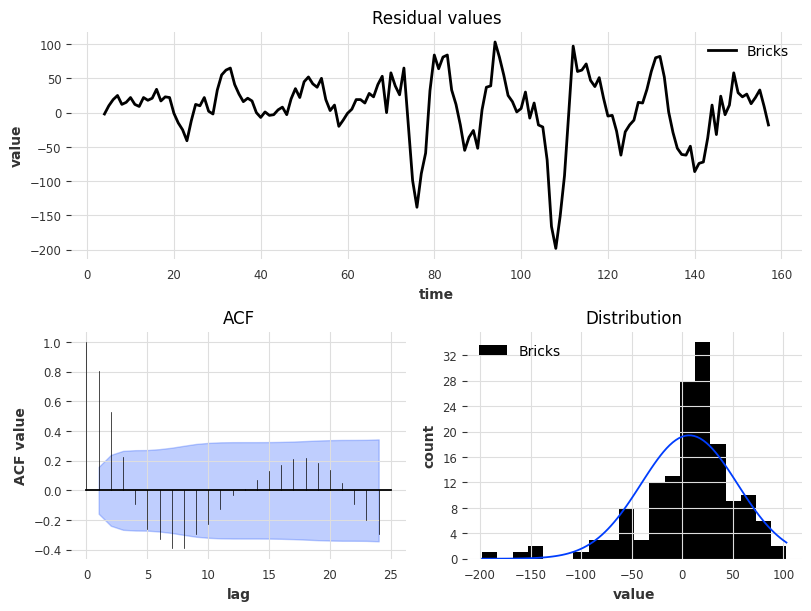

In [279]:
plot_residuals_analysis(model.residuals(train_series))

## Exercise 7

 For your retail time series (from Exercise 7 in Section 2.10):

a. Create a training dataset consisting of observations before 2011 using

```{r}
myseries_train <- myseries |>
  filter(year(Month) < 2011)
```


In [280]:
np.random.seed(12345678)

random_series_id = df_retail['Series ID'].sample(n=1).iloc[0]

myseries = df_retail[df_retail['Series ID'] == random_series_id]
myseries = myseries.set_index('Month')
myseries_train = myseries.query('Month < 2011')
myseries_test = myseries.query('Month >= 2011')

In [281]:
myseries = myseries[['Turnover']]

In [282]:
myseries

,Turnover
Month,
1982-04-01,39.7
1982-05-01,45.7
1982-06-01,43.9
1982-07-01,49.3
1982-08-01,48.9
...,...
2018-08-01,254.9
2018-09-01,260.1
2018-10-01,292.3



b. Check that your data have been split appropriately by producing the following plot.

```{r}
autoplot(myseries, Turnover) +
  autolayer(myseries_train, Turnover, colour = "red")
```

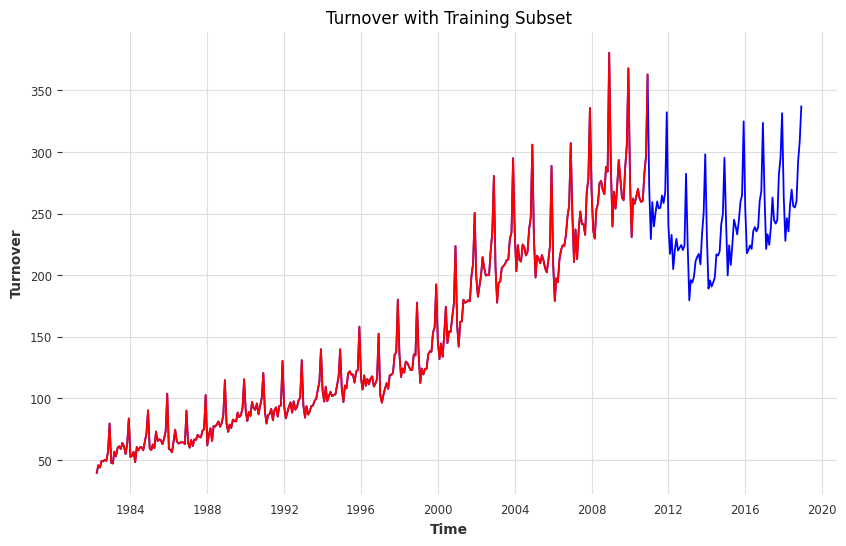

In [283]:

plt.plot(myseries['Turnover'], color='blue')  


plt.plot(myseries_train['Turnover'], color='red')

plt.xlabel('Time') 
plt.ylabel('Turnover')
plt.title('Turnover with Training Subset') 

plt.show()

In [284]:
myseries_train.shape


(345, 5)


c. Fit a seasonal naïve model using SNAIVE() applied to your training data (myseries_train).
```{r}
fit <- myseries_train |>
  model(SNAIVE())
```


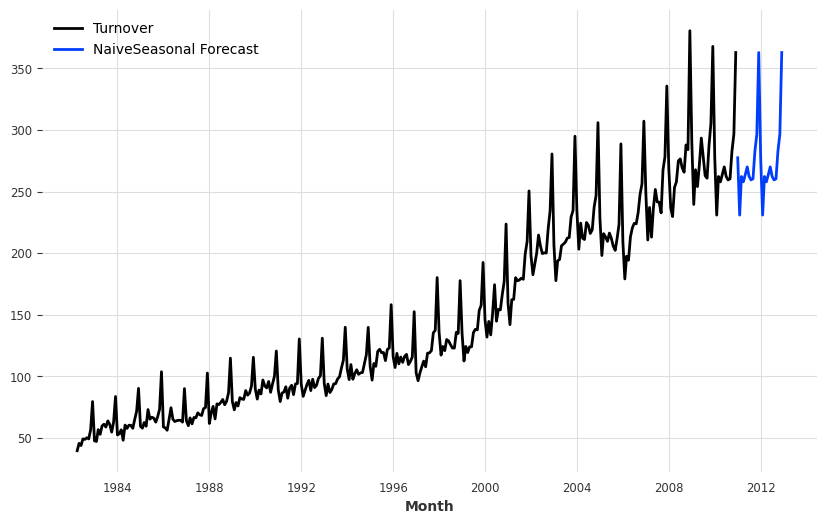

In [285]:
series = TimeSeries.from_dataframe(myseries, value_cols='Turnover')  
size =345
series_train = series[:size]
series_test = series[size:]
model = NaiveSeasonal(K=12) 
model.fit(series_train)

forecasts = model.predict(24) 
series_train.plot()
forecasts.plot(label='NaiveSeasonal Forecast')
plt.legend()
plt.show()


d. Check the residuals.
```{r}
fit |> gg_tsresiduals()
```
Do the residuals appear to be uncorrelated and normally distributed?


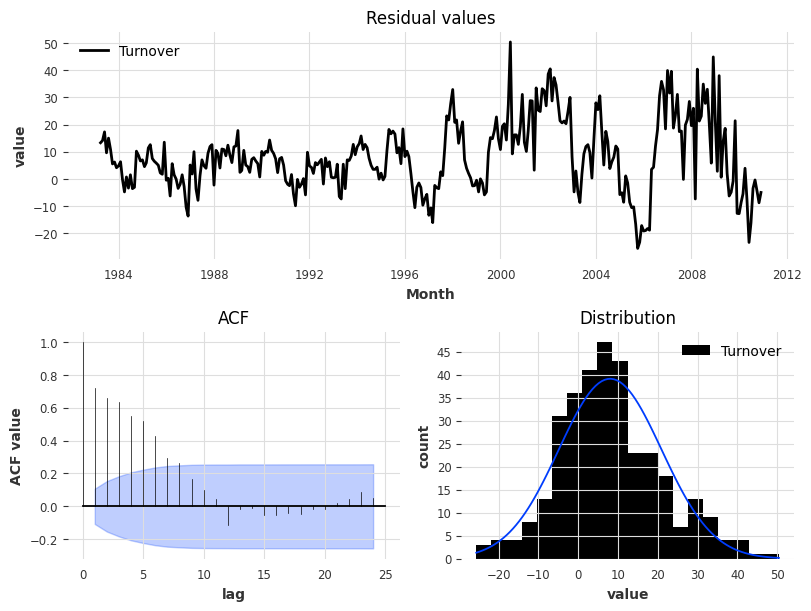

In [286]:
plot_residuals_analysis(model.residuals(series_train))

The residuals appear to be correleted until lag 8. While the histogram does look normal but is not center at zero. It seams to have mean of 8 by visually looking at the plot.


e.Produce forecasts for the test data

```{r}
fc <- fit |>
  forecast(new_data = anti_join(myseries, myseries_train))
fc |> autoplot(myseries)
```



f. Compare the accuracy of your forecasts against the actual values.

```{r}
fit |> accuracy()
fc |> accuracy(myseries)
```



In [287]:
from darts.metrics import mape

mape(series_test, forecasts)

12.338808133431534

Our forecast accuracy is 88% since we have mape value of 12.33 tells us that, on average, the forecasts is off by 12%. Ideally, we would want our mape value to be close to zero as possible.

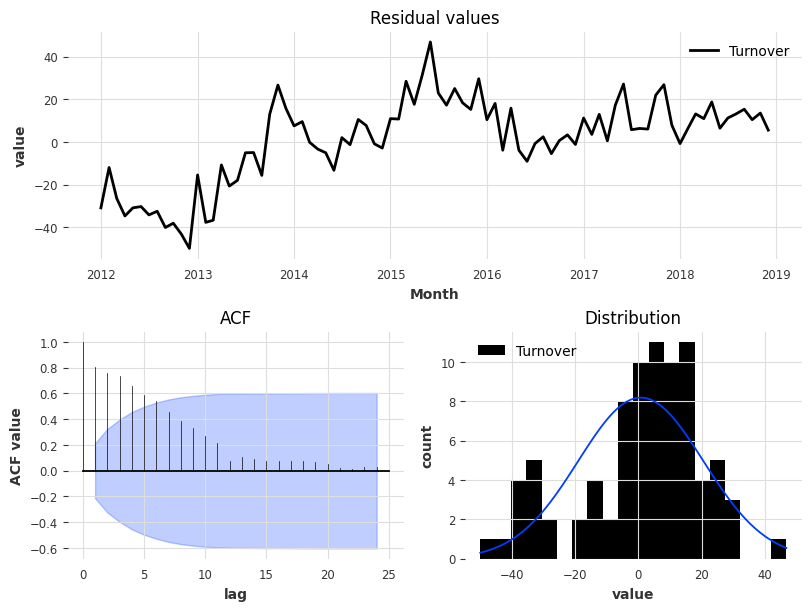

In [288]:

plot_residuals_analysis(model.residuals(series_test))



g.How sensitive are the accuracy measures to the amount of training data used?

The size of the training data definitely has an impact on the accuracy of the measurements since the more data a model learn from generally a better model. We should account the complexity of the model we plan to imploy since more complex models require a larger training datset relative to simple one, for instance a simple linear regression. Moreover, there are some measures that are more robust than ones to the size of the training data. We can assume that the sensitivity of the measurements have high variation between the different prediction models and performance metrics.